<a href="https://colab.research.google.com/github/XNN19/CCN2024/blob/main/RSA/demo_CCN2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook gives a quick overview on how to use the rsatoolbox.

As a first step you should run "Preparations". This will install rsatoolbox and a few tools the demo requires. You only need to look in there if you want to learn how to install the toolbox locally.

After running Preparations, the sections of this demo are independent. Feel free to skip to the section you care about most:

- *Loading data* teaches you how to get fMRI data into the toolbox.
- *Computing and comparing RDMs* teaches you about the basic functions for handling RDMs. Here, you can see how to compute the new RDM comparison methods as well.
- *Bootstrapping & Crossvalidation* finally teaches you how to perform interence to test whether differences between models are significant.

Have fun with the demos!

# Preparations

This section runs a few preparatory things. It will install rsatoolbox on your instance, download the example data, and set a few settings

In [ ]:
#!pip install rsatoolbox
!pip install git+https://github.com/rsagroup/rsatoolbox@bug_fix_concat
!pip install matplotlib
!pip install neuroimagingtools
!git clone https://github.com/rsagroup/rsatoolbox

  Cloning https://github.com/rsagroup/rsatoolbox (to revision bug_fix_concat) to /tmp/pip-req-build-xs438k5q
  Running command git clone --filter=blob:none --quiet https://github.com/rsagroup/rsatoolbox /tmp/pip-req-build-xs438k5q
  Running command git checkout -b bug_fix_concat --track origin/bug_fix_concat
  Switched to a new branch 'bug_fix_concat'
  Branch 'bug_fix_concat' set up to track remote branch 'bug_fix_concat' from 'origin'.
  Resolved https://github.com/rsagroup/rsatoolbox to commit 3041f0d8856e0d228a234a3bebc4f74d77a7d464
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for rsatoolbox: filename=rsatoolbox-0.1.6.dev217-cp310-cp310-linux_x86_64.whl size=606700 sha256=54d488878d8d72791cacafbf83e4eed3c1f6dbf51809a9a19fbfe27f452b0cb4
  Stored in directory: /tmp/pip-ephem-wheel-cache-i7dhvsgf/wheels/32/a6/ed/51140424102339b44a3dd1251cff2c4f080dba4d41b1e13151
Successfully built

In [ ]:
# imports
import os
import numpy as np
import pandas as pd
from scipy import io
import rsatoolbox
import rsatoolbox.data as rsd # abbreviation to deal with dataset
import rsatoolbox.rdm as rsr
from rsatoolbox.data import Dataset
from rsatoolbox.io.spm import SpmGlm
import matplotlib.pyplot as plt
%matplotlib inline

# Loading data (fMRI example)

In this part you will load some data from fMRI datasets to compute RDMs from.


This is an example of RSA on a fMRI dataset that was analyzed with SPM. The data is described in the following papers:

- Diedrichsen, J., Wiestler, T., & Krakauer, J. W. W. (2013). Two distinct ipsilateral cortical representations for individuated finger movements. Cerebral Cortex , 23(6), 1362–1377.
- Ejaz, N., Hamada, M., & Diedrichsen, J. (2015). Hand use predicts the structure of representations in sensorimotor cortex. Nature Neuroscience, 18(7), 1034–1040.

In the paradigm, participants made individual finger presses with one of the 5 fingers of the left or right hand. The data was preprocessed and analyzed with SPM. We are providing and analyzing only one single subject's data here

## Creating a RSAtoolbox dataset

First we need to download and unzip the data, which is done by the following cell:

In [ ]:
!wget https://www.dropbox.com/scl/fo/94njk5dq80niybi57cfgj/AEfF_YbXg8G50l0xgXPNzEY?rlkey=9v7x4l03xpfjrn1b6tqetw9rf&e=1&st=lx9pont4
!unzip AEfF_YbXg8G50l0xgXPNzEY\?rlkey\=9v7x4l03xpfjrn1b6tqetw9rf -d data

--2024-07-30 13:15:55--  https://www.dropbox.com/scl/fo/94njk5dq80niybi57cfgj/AEfF_YbXg8G50l0xgXPNzEY?rlkey=9v7x4l03xpfjrn1b6tqetw9rf
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb10d7f8b862e7117b12bb5f1fc.dl.dropboxusercontent.com/zip_download_get/B7Fo-Yuso6D2W57zX_usyzfekfWXNKWwrPXJ2L4UxFwREg3o6bxZ_4jtIgzq_p0RMm05m1p_kTym_TuJRXAetEH5JjvZboILaC-jXz3gB4GGTw# [following]
--2024-07-30 13:15:58--  https://ucb10d7f8b862e7117b12bb5f1fc.dl.dropboxusercontent.com/zip_download_get/B7Fo-Yuso6D2W57zX_usyzfekfWXNKWwrPXJ2L4UxFwREg3o6bxZ_4jtIgzq_p0RMm05m1p_kTym_TuJRXAetEH5JjvZboILaC-jXz3gB4GGTw
Resolving ucb10d7f8b862e7117b12bb5f1fc.dl.dropboxusercontent.com (ucb10d7f8b862e7117b12bb5f1fc.dl.dropboxusercontent.com)... 162.125.4.15, 2620:100:6019:15::a27d:40f
Connecting to ucb10d7f8b862e7117b12bb5f1fc.dl.dropbo

Now, the data is saved in the folder 'data'. In particular glm_firstlevel contains the beta estimates from the analysis run in SPM and anat contains a few anatomical maps. Here we will load the data from left M1, i.e. primary motor cortex in the left hemisphere.

Rsatoolbox contains a bunch of helper functions to load neural data from standard formats like SPMs, or nilearn. The corresponding class for SPM is called `SpmGlm`, which takes a folder that contains the SPM output as input.

The only other ingredient we need to load betas into a dataset in rsatoolbox is a mask for the brain area we are interested in. For our example such a mask is found in `/anat/M1_L.nii` .

To annotate which betas correspond to which condition, we interpret the regressor names and accumulate them in a data frame called `info`. These will be attached to the dataset object as input for rsatoolbox.

In [ ]:
data_dir = 'data'
spm = SpmGlm(data_dir + '/glm_firstlevel')
spm.get_info_from_spm_mat()
# Get the betas and residual mean-square image for left M1
[beta,ResMS,info]=spm.get_betas(data_dir + '/anat/M1_L.nii')
print(f'Shape of Betas: {beta.shape[0]}x{beta.shape[1]}')
# Extract digit and hand number from regressor names
info = pd.DataFrame(info)
info['hand']=[int(r[4]) for r in info['reg_name']]
info['digit']=[int(r[11]) for r in info['reg_name']]
info['condition']=(info['hand']-1)*5+info['digit']
info

Shape of Betas: 80x362


,reg_name,run_number,hand,digit,condition
0,hand1_digit1*bf(1),1,1,1,1
1,hand1_digit2*bf(1),1,1,2,2
2,hand1_digit3*bf(1),1,1,3,3
3,hand1_digit4*bf(1),1,1,4,4
4,hand1_digit5*bf(1),1,1,5,5
...,...,...,...,...,...
75,hand2_digit1*bf(1),8,2,1,6
76,hand2_digit2*bf(1),8,2,2,7
77,hand2_digit3*bf(1),8,2,3,8
78,hand2_digit4*bf(1),8,2,4,9


Now we can create a dataset from the data we collected. Here `measurements` are the betas we got from the first level GLM and `obs_descriptors` are a dictionairy of annotations for each measurement, i.e. our `info` list we just created.

In [ ]:
data = Dataset(
            measurements=beta/np.sqrt(ResMS),
            obs_descriptors=dict(info)
)

## Computing a simple RDM

Now we can immediately compute an RDM for this subject using `rsatoolbox.rdm.calc_rdm`, see below for more options for this step.

In [ ]:
RDM_uni = rsatoolbox.rdm.calc_rdm(
    data,
    method='crossnobis',
    descriptor='condition',
    cv_descriptor='run_number')

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


Now let's have a quick look to confirm that we got the right RDMs here:

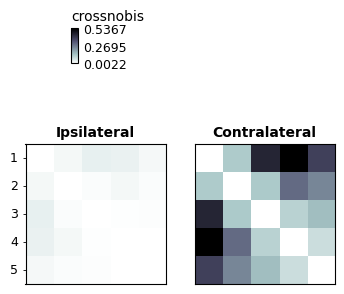

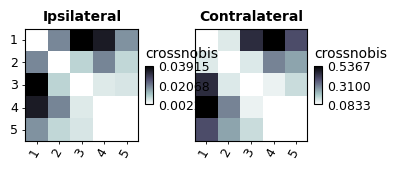

In [ ]:
# separate the part for the left and right hand
left_hand_rdm = RDM_uni.subset_pattern('hand', 1)
right_hand_rdm = RDM_uni.subset_pattern('hand', 2)

# Plot the two together (note the different color scales)
RDMs = rsatoolbox.rdm.concat([left_hand_rdm, right_hand_rdm], target_pdesc='digit')
RDMs.rdm_descriptors['name'] = ['Ipsilateral', 'Contralateral']
rsatoolbox.vis.show_rdm(RDMs, pattern_descriptor='digit', rdm_descriptor='name', show_colorbar="figure")
plt.show()
rsatoolbox.vis.show_rdm(RDMs, pattern_descriptor='digit', rdm_descriptor='name', show_colorbar="panel")
plt.show()

The rows and columns are in the order of the fingers (thumb to pinky). Note the gradual increase in dissimilarity by distance and the especially large distances to the thumb.

## RDM from multivariate pattern analysis

As explained in the talk, it is often a good idea to take the noise distribution of the patterns into account to weight the voxels for the calculation of distances. This is also know as multivariate pre-whitening. To do this we need additional information from the original time series.

For multivariate pre-whitening, we need to go back to the original time series data to obtain the residuals from the first-level analysis. These are not saved by default in SPM, so we need to recompute them. While it would be possible to save the residuals in the first-level analysis, this would require a lot of disk space. Instead, we can use the original data and the design matrix to compute the residuals and betas on the fly.

To implement this rsatoolbox provides some helper functions. Here `get_residuals` of the spm package and `prec_from_residuals`, which allows a shrinkage estimate of the covariance estimate from the residuals.

Shape of Betas: 80x362


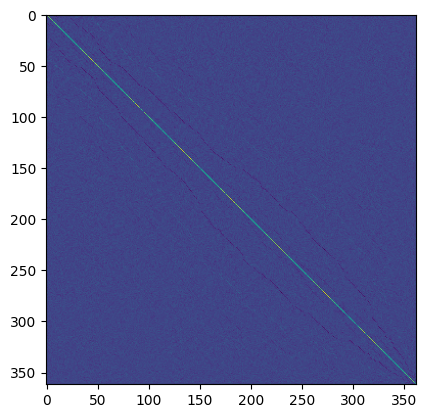

In [ ]:
# Get the betas and residual mean-square image for left M1
[residuals,beta,info] = spm.get_residuals(data_dir + '/anat/M1_L.nii')
print(f'Shape of Betas: {beta.shape[0]}x{beta.shape[1]}')
# Compute precision matrix (inverse of covariance matrix) from residuals
Prec = rsatoolbox.data.noise.prec_from_residuals(
            residuals,
            dof=spm.eff_df,
            method='shrinkage_diag'
        )
plt.imshow(Prec)

To use this computed precision matrix, simply pass it as `noise` to the RDM calculation procedure:

In [ ]:
# Calculate the RDM on all ten conditions.
RDM_multi = rsatoolbox.rdm.calc_rdm(
    data,
    method='crossnobis',
    noise = Prec,
    descriptor='condition',
    cv_descriptor='run_number')


/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


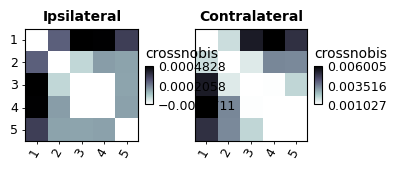

In [ ]:
# seperate the part for the left and right hand
left_hand_rdm = RDM_multi.subset_pattern('hand', 1)
right_hand_rdm = RDM_multi.subset_pattern('hand', 2)

# Plot the two together (note the different color scales)
RDMs=rsatoolbox.rdm.concat([left_hand_rdm,right_hand_rdm], target_pdesc='digit')
RDMs.rdm_descriptors['name']=['Ipsilateral','Contralateral']
rsatoolbox.vis.show_rdm(RDMs,pattern_descriptor='digit',rdm_descriptor='name', show_colorbar="panel")
plt.show()

Note the subtle differences between these RDMs and to the ones computed without taking the noise covariance matrix into account.

# Computing and comparing RDMs

In this section, you will use rsatoolbox to compute RDMs and compare them to each other.

We first generate an example dataset we want to calculate RDM(s) from. A dataset object contains an annotated array of data. If you have a data array and know which row of it corresponds to which input stimulus this should be fairly straight forward to create. If you want to learn about some of the intricacies of doing this for fMRI data have a look at the previous section. Additionally we have a few more examples in the rsatoolbox documentation.

For this tutorial we use simulated data for the 92 image dataset, which come with the toolbox and are here just loaded:

In [ ]:
# create a dataset object
measurements = io.matlab.loadmat('rsatoolbox/demos/92imageData/simTruePatterns.mat')
measurements = measurements['simTruePatterns2']
nCond = measurements.shape[0]
nVox = measurements.shape[1]
# now create a  dataset object
des = {'session': 1, 'subj': 1}
obs_des = {'conds': np.array(['cond_%02d' % x for x in np.arange(nCond)])}
chn_des = {'voxels': np.array(['voxel_' + str(x) for x in np.arange(nVox)])}
data = rsd.Dataset(measurements=measurements,
                   descriptors=des,
                   obs_descriptors=obs_des,
                   channel_descriptors=chn_des)

## Basic RDM handling


The main function to calculate RDMs from data is `rsatoolbox.rdm.calc_rdm` to which we have abbreviated access as `rsr.calc_rdm` here. The function takes a dataset object as its main input. Additionally, we here pass the descriptor 'conds' to specify that we want to create a RDM of dissimilarities between conditions as specified by 'conds'. If this input is not provided the RDM is calculated assuming that each row is a separate pattern or condition. To avoid confusion, we generally recommend to pass the `descriptor` argument.

In [ ]:
# calculate a RDM
RDM_euc = rsr.calc_rdm(data, descriptor='conds')
print(RDM_euc)

rsatoolbox.rdm.RDMs
1 RDM(s) over 92 conditions

dissimilarity_measure = 
squared euclidean

dissimilarities[0] = 
[[0.         1.79168033 1.79025977 ... 2.34585297 2.34306615 2.37794181]
 [1.79168033 0.         1.82424097 ... 2.3153871  2.28580169 2.32155829]
 [1.79025977 1.82424097 0.         ... 2.40876617 2.36854597 2.32501722]
 ...
 [2.34585297 2.3153871  2.40876617 ... 0.         1.76469464 1.72393365]
 [2.34306615 2.28580169 2.36854597 ... 1.76469464 0.         1.78983719]
 [2.37794181 2.32155829 2.32501722 ... 1.72393365 1.78983719 0.        ]]

descriptors: 

rdm_descriptors: 
session = [1]
subj = [1]
index = [0]

pattern_descriptors: 
conds = ['cond_00', 'cond_01', 'cond_02', 'cond_03', 'cond_04', 'cond_05', 'cond_06', 'cond_07', 'cond_08', 'cond_09', 'cond_10', 'cond_11', 'cond_12', 'cond_13', 'cond_14', 'cond_15', 'cond_16', 'cond_17', 'cond_18', 'cond_19', 'cond_20', 'cond_21', 'cond_22', 'cond_23', 'cond_24', 'cond_25', 'cond_26', 'cond_27', 'cond_28', 'cond_29', 'cond_30

As you see the RDMs object can be printed for easy inspection.
The calculated dissimilarities are saved as a vector of strung-out upper-triangular elements of the RDM matrix. Note also that the RDM object inherits the descriptors from the dataset object.

By default `calc_rdm` computes squared euclidean distances between mean patterns. If we want to compute a different type of RDM, we can do so by passing the `method` parameter. See https://rsa3.readthedocs.io/en/latest/distances.html for a discussion of different methods for calculating RDMs.
For example we can calculate correlation distances like this:

In [ ]:
RDM_corr = rsr.calc_rdm(data, method='correlation', descriptor='conds')


For the Euclidean and Mahalanobis distances there are squared and non-squared variants, which are both used sometimes. By default rsatoolbox calculates the squared dissimilarities. To compute non-square distances, use the sqrt_transform function in rsatoolbox.rdm. To compute a non-squared euclidean distance RDM this would look like this:

In [ ]:
RDM_euc = rsr.calc_rdm(data, method='euclidean', descriptor='conds')
RDM_euc_nonsquared = rsatoolbox.rdm.sqrt_transform(RDM_euc)

The squared distances are the default here. This fits the explanations from the keynote, as these are the ones that are the basis for analyses that are equivalent to Centered Kernel Alignment, or Prokrustes Shape Metrics.

### accessing RDM contents
To access the dissimilarities saved in the rdms object use the `get_matrices` and `get_vectors` functions. These functions always have a starting dimension for multiple rdms as the rdms object can store multiple rdms.

In [ ]:
dist_vectors = RDM_euc.get_vectors() # here a vector
dist_matrix = RDM_euc.get_matrices()
print(dist_matrix)
print(dist_matrix.shape)
print(dist_vectors.shape)

[[[0.         1.79168033 1.79025977 ... 2.34585297 2.34306615 2.37794181]
  [1.79168033 0.         1.82424097 ... 2.3153871  2.28580169 2.32155829]
  [1.79025977 1.82424097 0.         ... 2.40876617 2.36854597 2.32501722]
  ...
  [2.34585297 2.3153871  2.40876617 ... 0.         1.76469464 1.72393365]
  [2.34306615 2.28580169 2.36854597 ... 1.76469464 0.         1.78983719]
  [2.37794181 2.32155829 2.32501722 ... 1.72393365 1.78983719 0.        ]]]
(1, 92, 92)
(1, 4186)


Also, for a quick look we can plot the RDM using `rsatoolbox.vis.show_rdm`:

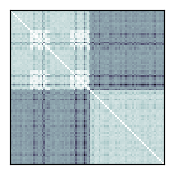

In [ ]:
fig, ax, ret_val = rsatoolbox.vis.show_rdm(RDM_euc)

If you already calculated a RDM in some different way you can turn your RDM into a RDM object for use in rsatoolbox by using the constructor `rsatoolbox.rdm.RDMs`. If you want to use descriptors for the conditions or rdms you put into the object you need to specify them as dictionaries of lists as for the dataset object.

The following thus creates a naked RDMs object, which only contains the dissimilarities and no specific descriptors.

In [ ]:
# create an RDM object with given entries:
dissimilarities = RDM_euc.get_vectors()
RDM_euc_manual = rsr.RDMs(dissimilarities)

### create RDM object for several RDMs


When we have multiple datasets we can compute the RDMs for each by simply passing the whole list to the function. This is convenient when we want to compute RDMs for multiple subjects, conditions, brain areas, etc.

To illustrate this let's start by creating a list of 5 datasets with noisy copies of the measurements we already have, labeling them as coming from different subjects in the descriptor `'subj'`:

In [ ]:
data_list = []
for i in range(5):
    m_noisy = measurements + np.random.randn(*measurements.shape)
    des = {'session': 1, 'subj': i}
    data_list.append(rsd.Dataset(measurements=m_noisy,
                   descriptors=des,
                   obs_descriptors=obs_des,
                   channel_descriptors=chn_des))

As promised we can now calculate the RDMs for all subjects in one go:

In [ ]:
rdms = rsr.calc_rdm(data_list)

In [ ]:
rdms

rsatoolbox.rdm.RDMs(
dissimilarity_measure = 
squared euclidean
dissimilarities = 
[[3.36028361 3.71566292 4.0995514  ... 3.24287563 3.45311207 3.89657436]
 [3.52796267 3.77020947 3.88631184 ... 3.91449383 3.53301826 3.16243192]
 [3.93377968 2.92919819 3.36346063 ... 4.72037617 4.38197014 3.96465655]
 [3.59451318 3.47792733 3.67335842 ... 3.57873438 4.34123405 4.22054962]
 [3.91238827 4.85839594 4.20784388 ... 3.71837613 4.1707546  4.58020779]]
descriptors = 
{}
rdm_descriptors = 
{'session': [1, 1, 1, 1, 1], 'index': [0, 1, 2, 3, 4], 'subj': [0, 1, 2, 3, 4]}
pattern_descriptors = 
{'conds': array(['cond_00', 'cond_01', 'cond_02', 'cond_03', 'cond_04', 'cond_05',
       'cond_06', 'cond_07', 'cond_08', 'cond_09', 'cond_10', 'cond_11',
       'cond_12', 'cond_13', 'cond_14', 'cond_15', 'cond_16', 'cond_17',
       'cond_18', 'cond_19', 'cond_20', 'cond_21', 'cond_22', 'cond_23',
       'cond_24', 'cond_25', 'cond_26', 'cond_27', 'cond_28', 'cond_29',
       'cond_30', 'cond_31', 'cond_3

In [ ]:
rdms.pattern_descriptors.keys()

dict_keys(['conds', 'index'])

Note, that `rdms` is a single object, which contains all RDMs. The functions for accessing the vector representation and the matrix representation are still available. Additionally, the number of RDMs and the descriptiors we gave to the dataset objects are kept:

In [ ]:
print('The number of RDMs is:')
print(rdms.n_rdm)
print()
print('The descriptors for the RDMs are:')
print(rdms.rdm_descriptors)
print()
print('The patterns or conditions are still described at least by their label:')
print(rdms.pattern_descriptors['conds'])

The number of RDMs is:
5

The descriptors for the RDMs are:
{'session': [1, 1, 1, 1, 1], 'index': [0, 1, 2, 3, 4], 'subj': [0, 1, 2, 3, 4]}

The patterns or conditions are still described at least by their label:
['cond_00' 'cond_01' 'cond_02' 'cond_03' 'cond_04' 'cond_05' 'cond_06'
 'cond_07' 'cond_08' 'cond_09' 'cond_10' 'cond_11' 'cond_12' 'cond_13'
 'cond_14' 'cond_15' 'cond_16' 'cond_17' 'cond_18' 'cond_19' 'cond_20'
 'cond_21' 'cond_22' 'cond_23' 'cond_24' 'cond_25' 'cond_26' 'cond_27'
 'cond_28' 'cond_29' 'cond_30' 'cond_31' 'cond_32' 'cond_33' 'cond_34'
 'cond_35' 'cond_36' 'cond_37' 'cond_38' 'cond_39' 'cond_40' 'cond_41'
 'cond_42' 'cond_43' 'cond_44' 'cond_45' 'cond_46' 'cond_47' 'cond_48'
 'cond_49' 'cond_50' 'cond_51' 'cond_52' 'cond_53' 'cond_54' 'cond_55'
 'cond_56' 'cond_57' 'cond_58' 'cond_59' 'cond_60' 'cond_61' 'cond_62'
 'cond_63' 'cond_64' 'cond_65' 'cond_66' 'cond_67' 'cond_68' 'cond_69'
 'cond_70' 'cond_71' 'cond_72' 'cond_73' 'cond_74' 'cond_75' 'cond_76'
 'cond

### Splitting RDMs objects



To access the parts of the rdms object a few functions are available:

To access only a subset of the rdms in the object use the `subset` and `subsample` functions:
The inputs to these functions are a descriptor used for the selection and a list (or other iterable) of selected values.

The difference between the two function lies in how they treat repetitions. If you pass a value twice subsample will repeat the rdm in the returned object, while subset will return every rdm at most once.

In [ ]:
# same output:
r1 = rdms.subset('subj', [1, 3, 4])
r2 = rdms.subsample('subj', [1, 3, 4])
# different output
r3 = rdms.subset('subj', [1, 3, 3, 4])
r4 = rdms.subsample('subj', [1, 3, 3, 4])
# r3 has 3 rdms r4 has 4 rdms

Equivalent syntax for selecting a subset of the patterns is implemented as `subset_pattern` and `subsample_pattern`.

For repeated values subsample will fill in dissimilarities between patterns and themselves as `np.nan`.

In [ ]:
# same output:
r1 = rdms.subset_pattern('conds', [f"cond_{i:02}" for i in [1, 3, 4, 5, 6, 72]])
r2 = rdms.subsample_pattern('conds', [f"cond_{i:02}" for i in [1, 3, 4, 5, 6, 72]])
print(r1==r2)
# different output
r3 = rdms.subset_pattern('conds', [f"cond_{i:02}" for i in [1, 3, 3, 5, 6, 72]])
r4 = rdms.subsample_pattern('conds', [f"cond_{i:02}" for i in [1, 3, 3, 5, 6, 72]])
# r3 has 5 conditions r4 has 6 conditions
print(r3.n_cond)
print(r4.n_cond)


True
5
6


Indexing and iterating over RDMs is also supported, i.e. `rdms[0]` will return the first rdm and `for rdm in rdms:` are legal commands. These commands return copies though!, i.e. `rdms[0]` and `rdm` will be copies of the corresponding rdms and changing them will not affect the original rdms object.

And of course we can still show the rdm in a plot using `rsatoolbox.vis.show_rdm`:

(<Figure size 600x400 with 6 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object),
 {-1: {},
  0: {},
  1: {'image': <matplotlib.image.AxesImage at 0x7815f87c7820>},
  2: {'image': <matplotlib.image.AxesImage at 0x7815f8958220>},
  3: {'image': <matplotlib.image.AxesImage at 0x7815f878cc40>},
  4: {'image': <matplotlib.image.AxesImage at 0x7815f87c5300>},
  5: {'image': <matplotlib.image.AxesImage at 0x7815f87f9c30>}})

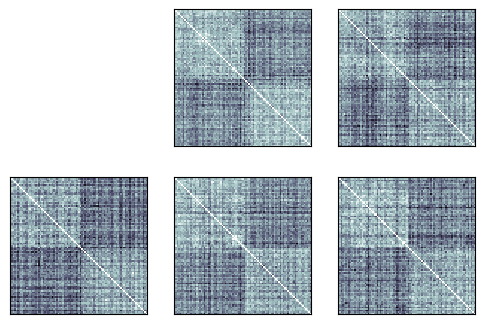

In [ ]:
rsatoolbox.vis.show_rdm(rdms)


## Crossvalidated dissimilarities

When we have multiple independent measurements of a pattern we can use crossvalidated distances to achieve an unbiased estimate of the dissimilarities between patterns. Essentially, this is meant to counteract the upward bias caused by adding noise to the measurements. You may have noticed this bias by comparing the noisy RDMs we just created and the clean rdm we created at the beginning of this tutorial.

To illustrate how to do this using rsatoolbox, we first create a dataset with multiple (`n_rep`) measurements for each pattern:

In [ ]:
n_rep = 3
m_noisy = np.repeat(measurements, n_rep, axis=0)
m_noisy += np.random.randn(*m_noisy.shape)

conds = np.array(['cond_%02d' % x for x in np.arange(nCond)])
sessions = np.tile(np.arange(n_rep), 92)
conds = np.repeat(conds, n_rep)
obs_des = {'conds': conds, 'sessions': sessions}

des = {'subj': 1}

dataset = rsd.Dataset(
    measurements=m_noisy,
    descriptors=des,
    obs_descriptors=obs_des,
    channel_descriptors=chn_des)

Importantly, we added a sessions descriptor which marks which measurement comes from which session. We can now compute the crossvalidated distances simply using the `'crossnobis'` rdm calculation method. To specify which measurements come from the same session we pass `'sessions'` as the `cv_descriptor`.

In [ ]:
rdm_cv = rsatoolbox.rdm.calc_rdm(dataset, method='crossnobis', descriptor='conds', cv_descriptor='sessions')

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


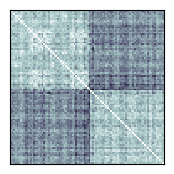

In [ ]:
rsatoolbox.vis.show_rdm(rdm_cv)
None

Looking at this rdm, we can see that this indeed removed the overall upward bias, although the rdm is still noisy of course. If you have multiple datasets for multiple subjects this will still work fine with the crossnobis dissimilarity.

## Taking the noise covariance into account


It is possible to take into account the noise covariance to get a more reliable estimate of the RDM. For computational efficiency reasons all functions which compute these dissimilarities in this toolbox take the precision matrix as input.

To do so, the first step is to estimate the noise precision matrix. There are multiple estimates implemented in rsatoolbox.




### diagonal covariance from measurements = univariate noise normalization


The first one is computing the variances and using the diagonal precision matrix, which is equivalent to normalizing each channel separately.

In [ ]:
# the covariance is never used in rsatoolbox
# noise_cov_diag = rsatoolbox.data.noise.cov_from_measurements(dataset, obs_desc='conds', method='diag')
# computing the precision matrix (inverse of CoV) instead:
noise_prec_diag = rsatoolbox.data.noise.prec_from_measurements(dataset, obs_desc='conds', method='diag')

### shrinkage estimate from measurements = multivariate noise normalization


The second method for estimating the noise covariance are shrinkage estimates which mix a diagonal matrix with the sample covariance to achieve an invertible, more accurate estimate of the covariance.

In rsatoolbox this is implemented in the same function, just changing the method parameter. There are two variants: `'shrinkage_eye'` implements a shrinkage towards a multiple of the diagonal, `'shrinkage_diag'` shrinks towards the data diagonal.

In [ ]:
noise_prec_shrink = rsatoolbox.data.noise.prec_from_measurements(dataset, obs_desc='conds', method='shrinkage_eye')

In [ ]:
noise_prec_shrink = rsatoolbox.data.noise.prec_from_measurements(dataset, obs_desc='conds', method='shrinkage_diag')

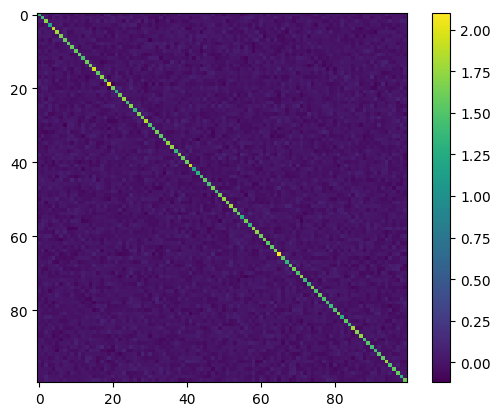

In [ ]:
plt.imshow(noise_prec_shrink), plt.colorbar()
None

### estimates based on residuals

A different source for the noise covariance can be measures from an earlier step in the analysis, which lead to the dataset object. Most of the times these measures would be the residuals of a 1st level analysis to estimate the activations caused by the conditions or stimuli.

To use this source for the noise covariance simply put the measurements you wish to use into a $n_{res}\times k$ matrix, where $k$ is the number of measurement channels and run the following commands from the noise handling in rsatoolbox:

In [ ]:
residuals = np.random.randn(1000, dataset.n_channel) # obviously do not use random residuals for this in applications
noise_pres_res = rsatoolbox.data.noise.prec_from_residuals(residuals)

`rsatoolbox.data.noise.prec_from_residuals` takes the same method argument as `prec_from_measurements` allowing for diagonal covariance and shrinkage estimates.

Also there is a `dof` argument, which allows you to provide the degrees of freedom left in the residuals to correct the estimate for components removed via regression. This only scales the matrix, which means that this can be ignored if the absolute scale of the RDM does not matter to you.

### Computing Mahalanobis distances


Mahalanobis distances is the simplest form of dissimilarities to take the covariance between measurement channels into account. This is reweighting channels with the estimate of the precision matrix.

In rsatoolbox this is implemented as the `'mahalanobis'` method parameter of `calc_rdm`. The noise precision is passed as the `noise` parameter. For comparison we here also compute the euclidean RDM on the original data:

In [ ]:
rdm_euc = rsatoolbox.rdm.calc_rdm(dataset, descriptor='conds', method='euclidean')
rdm_maha_diag = rsatoolbox.rdm.calc_rdm(dataset, descriptor='conds', method='mahalanobis', noise=noise_prec_diag)
rdm_maha_shrink = rsatoolbox.rdm.calc_rdm(dataset, descriptor='conds', method='mahalanobis', noise=noise_prec_shrink)

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


To compare the three estimated rdms, we can plot them with the following code. In this case the differences are fairly small, as we added independent and equally sized noise to the measurements. When the measurement channels are correlated and/or differently noisy this will result in larger differences..

In [ ]:
np.concatenate([rdm_euc.get_matrices(), rdm_maha_diag.get_matrices(), rdm_maha_shrink.get_matrices()], axis=0).shape

(3, 92, 92)

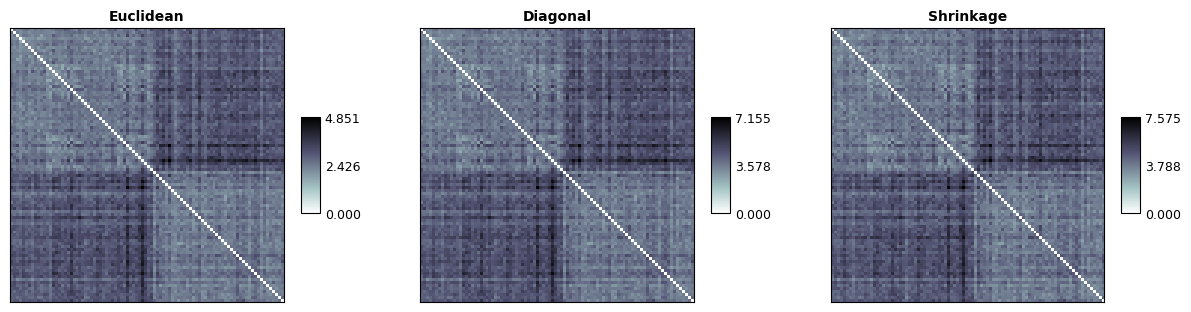

In [ ]:
rsatoolbox.vis.show_rdm(
    rsatoolbox.rdm.RDMs(
        np.concatenate(
            [rdm_euc.get_matrices(),
             rdm_maha_diag.get_matrices(),
             rdm_maha_shrink.get_matrices()],
            axis=0),
        rdm_descriptors=dict(method=('Euclidean', 'Diagonal', 'Shrinkage'))
    ),
    show_colorbar='panel',
    rdm_descriptor='method',
    vmin=0,
    n_row=1,
    figsize=(15,5)
)
None

Taking the noise covariance into account can be combined with crossvalidated dissimilarities by computing cross-nobis dissimilarities. This is implemented as the `crossnobis` method of calculating RDMs in rsatoolbox:

In [ ]:
rdm_cv_eye = rsatoolbox.rdm.calc_rdm(dataset, descriptor='conds', method='crossnobis', noise=None, cv_descriptor='sessions')
rdm_cv_diag = rsatoolbox.rdm.calc_rdm(dataset, descriptor='conds', method='crossnobis', noise=noise_prec_diag, cv_descriptor='sessions')
rdm_cv_shrink = rsatoolbox.rdm.calc_rdm(dataset, descriptor='conds', method='crossnobis', noise=noise_prec_shrink, cv_descriptor='sessions')

/usr/local/lib/python3.10/dist-packages/rsatoolbox/data/computations.py:36: RuntimeWarning: invalid value encountered in multiply
  average = np.nan * np.empty(
/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


And we can of course plot these matrices again:

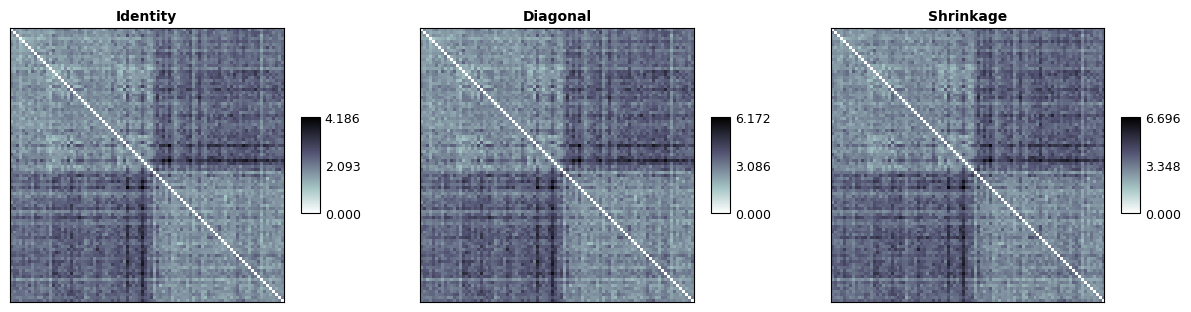

In [ ]:
rsatoolbox.vis.show_rdm(
    rsatoolbox.rdm.RDMs(
        np.concatenate(
            [rdm_cv_eye.get_matrices(),
             rdm_cv_diag.get_matrices(),
             rdm_cv_shrink.get_matrices()],
            axis=0),
        rdm_descriptors=dict(method=('Identity', 'Diagonal', 'Shrinkage'))
    ),
    show_colorbar='panel',
    rdm_descriptor='method',
    vmin=0,
    n_row=1,
    figsize=(15,5)
)
None

## Comparing RDMs

The main functions for comparing RDMs are found in `rsatoolbox.rdm`. The main function is `rsatoolbox.rdm.compare`:



In [ ]:
rsatoolbox.rdm.compare?

### Basic usage

Using this function we can compare RDMs objects with the same number of conditions. For example:

In [ ]:
rsatoolbox.rdm.compare(RDM_euc, rdm_cv, method='corr')

array([[0.82151386]])

This indicates that the RDM correlation between the euclidean and crossvalidated RDMs is the very high value of 0.8215

If we input RDMs objects that contain multiple RDMs, compare will compute all pairwise comparisons. For example, the following computes all pairwise comparisons between rdms we computed earlier:

In [ ]:
rsatoolbox.rdm.compare(rdms, rdms, method="corr")

array([[1.        , 0.3643453 , 0.432406  , 0.31464229, 0.32180044],
       [0.3643453 , 1.        , 0.32849837, 0.37828379, 0.31092736],
       [0.432406  , 0.32849837, 1.        , 0.3223486 , 0.35156594],
       [0.31464229, 0.37828379, 0.3223486 , 1.        , 0.31554089],
       [0.32180044, 0.31092736, 0.35156594, 0.31554089, 1.        ]])

And the following compares all rdms to RDM_cv:


In [ ]:
rsatoolbox.rdm.compare(rdm_cv, rdms, method="corr")

array([[0.48717164, 0.44242566, 0.52065458, 0.46119021, 0.46818829]])

### Equivalent analyses to other methods

In this section we will see the equivalent analyses as introduced in Alex Williams talk:

**Centered Kernel Alignment**

Centered kernel alignment is a popular method from computer science to compare different networks and their layers to each other. It turns out that this is exactly equivalent to the whitened cosine similarity between squared euclidean RDMs.

This particular similarity measure is called `cosine_cov` in the rsatoolbox. We can thus run a perfectly equivalent analysis to CKA in rsatoolbox with:

In [ ]:
rsatoolbox.rdm.compare(rdms, rdms, "cosine_cov")

array([[1.        , 0.69021707, 0.72257523, 0.68619354, 0.70072966],
       [0.69021707, 1.        , 0.69217861, 0.69991765, 0.67847409],
       [0.72257523, 0.69217861, 1.        , 0.70155379, 0.71469919],
       [0.68619354, 0.69991765, 0.70155379, 1.        , 0.70186967],
       [0.70072966, 0.67847409, 0.71469919, 0.70186967, 1.        ]])

**Procrustes shape metric**

As shown in the talk and other demos, there is a Kernel distance, which is equivalent to the Procrustes shape metric. This distance is named after "Bures" and can be computed in the rsatoolbox using `bures` as the method name as in the following:

In [ ]:
rsatoolbox.rdm.compare(rdms, rdms, "bures")

array([[1.        , 0.82453426, 0.82834265, 0.82324211, 0.82488393],
       [0.82453426, 1.        , 0.8230373 , 0.8328539 , 0.8171735 ],
       [0.82834265, 0.8230373 , 1.        , 0.82578804, 0.83478243],
       [0.82324211, 0.8328539 , 0.82578804, 1.        , 0.82874878],
       [0.82488393, 0.8171735 , 0.83478243, 0.82874878, 1.        ]])

For `bures` rsatoolbox gives you the Bures similarity, which is more consistent with the model evaluation functionality's expectation that high values indicate good model performance. If you desire the distance between representations or RDMs instead, use `bures_metric` as in the following:

In [ ]:
dist = rsatoolbox.rdm.compare(rdms, rdms, "bures_metric")
np.set_printoptions(precision=4)
print(dist)

[[ 6.2528e-13  6.4788e+01  6.3472e+01  6.6100e+01  6.5186e+01]
 [ 6.4788e+01 -2.2737e-13  6.5427e+01  6.2502e+01  6.8049e+01]
 [ 6.3472e+01  6.5427e+01 -5.6843e-14  6.5229e+01  6.1579e+01]
 [ 6.6100e+01  6.2502e+01  6.5229e+01 -1.7053e-13  6.4522e+01]
 [ 6.5186e+01  6.8049e+01  6.1579e+01  6.4522e+01 -1.0182e-07]]


Note that in this evaluation high values correspond to high differences. The small negative values are due to numerical error similar to the deviations that arise between the theoretically equivalent analyses.

**Cosine Angle: another metric on RDMs**

We noted that it is desireable to use a (pseudo-) metric on representations for subsequent analyses like embeddings or clustering. One other such metric is the cosine angle between RDMs. This can be computed as the arccos of the cosine similarity between rdms. This works for both the whitened and unwhitened cosine similarity.

In rsatoolbox this requires two steps: First compute cosine similarity and then apply the arccos to it:

In [ ]:
sim = rsatoolbox.rdm.compare(rdms, rdms, "cosine")
# We added a np.minimum(sim, 1) here to avoid numerical issues
# for cosine similarities > 1
dist = np.arccos(np.minimum(sim, 1))
print(dist)

[[0.     0.1645 0.1544 0.1694 0.1676]
 [0.1645 0.     0.1697 0.1631 0.1708]
 [0.1544 0.1697 0.     0.1692 0.1645]
 [0.1694 0.1631 0.1692 0.     0.1688]
 [0.1676 0.1708 0.1645 0.1688 0.    ]]


And equivalently for the whitened cosine similarity:

In [ ]:
sim = rsatoolbox.rdm.compare(rdms, rdms, "cosine_cov")
# We added a np.minimum(sim, 1) here to avoid numerical issues
# for cosine similarities > 1
dist = np.arccos(np.minimum(sim, 1))
print(dist)

[[1.4901e-08 8.0901e-01 7.6328e-01 8.1455e-01 7.9438e-01]
 [8.0901e-01 0.0000e+00 8.0629e-01 7.9551e-01 8.2511e-01]
 [7.6328e-01 8.0629e-01 0.0000e+00 7.9322e-01 7.7460e-01]
 [8.1455e-01 7.9551e-01 7.9322e-01 0.0000e+00 7.9278e-01]
 [7.9438e-01 8.2511e-01 7.7460e-01 7.9278e-01 0.0000e+00]]


# Bootstrapping & Crossvalidation for model tests




## Introduction

In these three exercises you will get an introduction to the functionality of the new RSA toolbox for inferring the underlying model representation based on measured data. Generally we assume that there is a true underlying representation, which is captured by our model. The measurement process like fMRI will lead to a distorted view of that representation, which we may or may not include into our analysis as an explicit measurement model.

All analyses described in this section work the same way for any method of calculating RDMs and any method for comparing them. Thus, they can effectively be applied to CKA, Prokrustes shape metrics or any other way of generating and comparing RDMs.

For illustration these exercises use simulated RDMs from the paper "Inferring brain-computational mechanisms with models of activity measurements" by Kriegeskorte & Diedrichsen (2016). Ground truth RDMs are here simulated based on the layers of Alexnet--the deep neural network model, which sparked the interest in deep learning. Simulated data rdms were generated as follows: First, voxel responses were generated by randomly selecting locations within the layer and modelling their response as a local average of the feature values. Then, noise was added to those voxel responses and RDMs were computed from these noisy responses. As model predictions to compare to, we use noise-free RDMs generated for each layer, by applying different amounts of smoothing and averaging to the layer representation.

Our overall aim in this setting is to infer which representation the data rdms were based on, i.e. which layer was used for generating the data. Towards this aim we will make three steps:

In *Exercise 1*, we will load the data, convert them into the formats used in the toolbox and have a first exploratory look at the data.

In *Exercise 2*, we will compare the RDMs based on the undistorted representations to the simulated data RDMs. This is the classical and simplest approach and already allows us to perform model comparisons and the general evaluation of model-RDMs. This approach uses *fixed models*, i.e. each model predicts a single fixed RDM. We will see that this does not allow us to correctly infer the underlying representation though, because the measurement process distorts the RDMs too much.

In *Exercise 3*, we will apply *flexible models*. This means that each model predicts a distribution of RDMs. In the present context this means that the model is flexible in which measurement model is applied to explain the data. To evaluate such flexible models additional cross-validation is necessary, which we also discuss in this exercise.

## Exercise 1: Data and RDM handling

In [ ]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import rsatoolbox
%matplotlib inline

### Load model RDMs
Here the models are different layers of Alexnet.
For each layer, different models of how the fMRI voxels sample the neurons are being considered.

The simulated data were generated in Matlab (Kriegeskorte & Diedrichsen 2016). Thus, we load the Matlab files in .mat format.

For each model-RDM, we obtain the RDM itself, a model name, and a measurement model name. The model name specifies the layer used to generate the RDM. The measurement model name specifies the applied distortions.

In [ ]:
matlab_data = io.matlab.loadmat('rsatoolbox/demos/rdms_inferring/modelRDMs_A2020.mat')
matlab_data = matlab_data['modelRDMs']
n_models = len(matlab_data[0])
model_names = [matlab_data[0][i][0][0] for i in range(n_models)]
measurement_model = [matlab_data[0][i][1][0] for i in range(n_models)]
rdms_array = np.array([matlab_data[0][i][3][0] for i in range(n_models)])

These steps are not specific to the toolbox, but to the format the RDMs were originally saved in.
To load other data, simply transform them such that they are numpy arrays of either the whole RDM or vector format of the upper triangular part of the matrix.

### Store the model RDMs as a rsatoolbox object
We place the RDMs in a rsatoolbox object which can contain additional descriptors for the RDMs and the experimental conditions.
Here we label each RDM with the name of the brain-computational model (AlexNet layer) and the name of the measurement model.

In [ ]:
model_rdms = rsatoolbox.rdm.RDMs(rdms_array,
                            rdm_descriptors={'brain_computational_model':model_names,
                                             'measurement_model':measurement_model},
                            dissimilarity_measure='Euclidean'
                           )

The variable model_rdms is now a custom object, which contains all the RDMs from the .mat file with the additional information.
It also has a few methods for forming subsets of the data, saving and loading, etc.

### Show the RDMs from AlexNet layer conv1

As a simple example, select the RDMs that correspond to the first convolutional layer. These can then be plotted using the function rsatoolbox.vis.show_rdm.

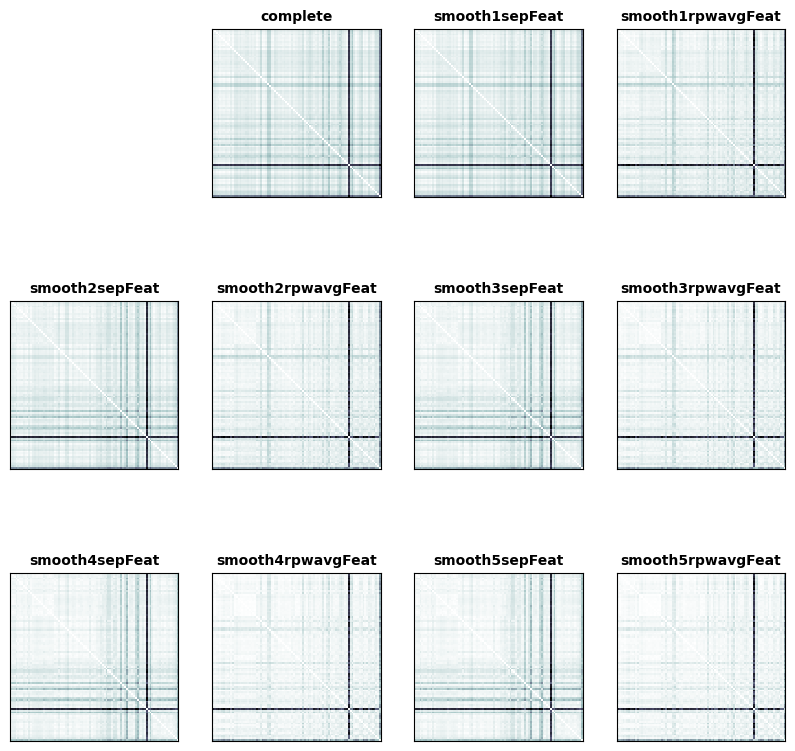

In [ ]:
conv1_rdms = model_rdms.subset('brain_computational_model','conv1')
fig, ax, ret_val = rsatoolbox.vis.show_rdm(conv1_rdms, rdm_descriptor='measurement_model', figsize=(10,10))

These are the RDMs which were generated from convolutional layer 1 by different measurement models. Each RDM is labeled with the name of the measurement model. Also in the lower right corner the average RDM is plotted.

### Print information about a set of RDMs


The rsatoolbox objects can simply be passed to the print function to obtain a short description of their content.

In [ ]:
conv1_rdms = model_rdms.subset('brain_computational_model','conv1')
print(conv1_rdms)

rsatoolbox.rdm.RDMs
11 RDM(s) over 92 conditions

dissimilarity_measure = 
Euclidean

dissimilarities[0] = 
[[0.00000000e+00 7.35978432e+08 5.35502528e+08 ... 1.34278669e+09
  1.34848320e+09 4.47360614e+09]
 [7.35978432e+08 0.00000000e+00 6.72164736e+08 ... 1.52816154e+09
  1.59405773e+09 4.56825293e+09]
 [5.35502528e+08 6.72164736e+08 0.00000000e+00 ... 1.40547021e+09
  1.39483494e+09 4.35671757e+09]
 ...
 [1.34278669e+09 1.52816154e+09 1.40547021e+09 ... 0.00000000e+00
  1.85234202e+09 4.90678682e+09]
 [1.34848320e+09 1.59405773e+09 1.39483494e+09 ... 1.85234202e+09
  0.00000000e+00 5.00813875e+09]
 [4.47360614e+09 4.56825293e+09 4.35671757e+09 ... 4.90678682e+09
  5.00813875e+09 0.00000000e+00]]

descriptors: 

rdm_descriptors: 
brain_computational_model = ['conv1', 'conv1', 'conv1', 'conv1', 'conv1', 'conv1', 'conv1', 'conv1', 'conv1', 'conv1', 'conv1']
measurement_model = ['complete', 'smooth1sepFeat', 'smooth1rpwavgFeat', 'smooth2sepFeat', 'smooth2rpwavgFeat', 'smooth3sepFeat', '

## Exercise 2: Fixed model inference


### Load data RDMs


Here we use simulated data to demonstrate RSA inference.
Since we know the true data-generating model in each case, we can tell when inference fails or succeeds.

For each data RDM, we obtain the name of the underlying Layer, a full width at half maximum (FWHM) value and a noise standard deviation. The FWHM value specifies the spatial range the simulated voxels average over. The noise standard deviation specifies how much noise was added to the voxel responses.

In [ ]:
matlab_data = io.matlab.loadmat('rsatoolbox/demos/rdms_inferring/noisyModelRDMs_A2020.mat')
repr_names_matlab = matlab_data['reprNames']
fwhms_matlab = matlab_data['FWHMs']
noise_std_matlab = matlab_data['relNoiseStds']
rdms_matlab = matlab_data['noisyModelRDMs']
repr_names = [repr_names_matlab[i][0][0] for i in range(repr_names_matlab.shape[0])]
fwhms = fwhms_matlab.squeeze().astype('float')
noise_std = noise_std_matlab.squeeze().astype('float')
rdms_matrix = rdms_matlab.squeeze().astype('float')


### Choose the data RDMs for inference



Here we choose which data RDMs we use for the exercise. You can change the representation, the noise level and the amount of averaging by chaning the index values at the beginning.

We then convert the chosen data RDMs into an rsatoolbox RDMs object and display them as we did for the model RDMs.

The chosen ground truth model is:
conv3
with noise level:
3.0
with averaging width (full width at half magnitude):
0.0


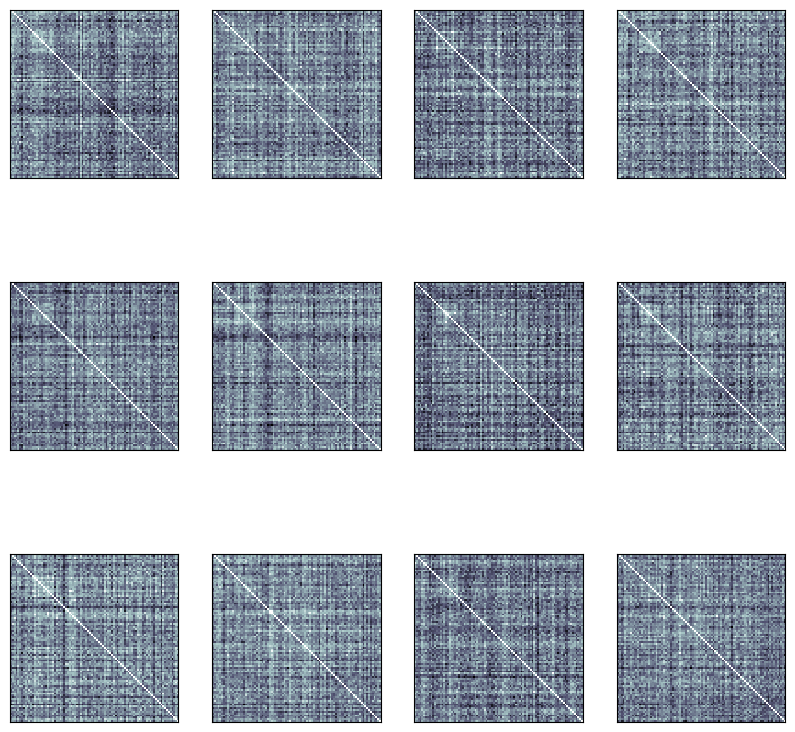

In [ ]:
# indices choosing brain-computational model, noise level, and the size of the kernel with which each voxel samples the neural activity
i_rep = 2 #np.random.randint(len(repr_names))
i_noise = 1 #np.random.randint(len(noise_std))
i_fwhm = 0 #np.random.randint(len(fwhms))

# print the chosen representation definition
repr_name = repr_names[i_rep]
print('The chosen ground truth model is:')
print(repr_name)
print('with noise level:')
print(noise_std[i_noise])
print('with averaging width (full width at half magnitude):')
print(fwhms[i_fwhm])

# put the rdms into an RDMs object and show it
rdms_data = rsatoolbox.rdm.RDMs(rdms_matrix[:, i_rep, i_fwhm, i_noise, :].transpose())

fig, ax, ret_val = rsatoolbox.vis.show_rdm(rdms_data, figsize=(10,10))

### Define fixed models


An "RDM model" is a rsatoolbox object that can predict a data RDM.
For example, a flexible RDM model may contain a set of predictor RDMs, which predict the data RDM as a weighted combination.
Here we use fixed RDM models, which contain just a single RDM with no parameters to be fitted.

Models are generated by first choosing the RDM, in this case the one with the right "brain_computational_model" and the "measurement_model" "complete", which corresponds to no distortions added. This object is then passed to the function `rsatoolbox.model.ModelFixed`, which generates a fixed RDM model. These RDM models are then collected in the list `models`.

In [ ]:
models = []
for i_model in np.unique(model_names):
    rdm_m = model_rdms.subset('brain_computational_model', i_model).subset('measurement_model','complete')
    m = rsatoolbox.model.ModelFixed(i_model, rdm_m)
    models.append(m)

print('created the following models:')
for i in range(len(models)):
    print(models[i].name)

created the following models:
conv1
conv2
conv3
conv4
conv5
fc6
fc7
fc8
prob


### Compare model RDMs to measured RDMs


Evaluate models naively, i.e. simply compute the average correlation to the data RDMs.

In [ ]:
rdms_data

rsatoolbox.rdm.RDMs(
dissimilarity_measure = 
None
dissimilarities = 
[[285.55175781 293.54159546 296.19104004 ... 298.66671753 291.25585938
  301.21057129]
 [294.75619507 303.51464844 295.31863403 ... 303.96090698 299.55621338
  303.85379028]
 [301.32626343 298.68527222 304.10681152 ... 283.83795166 294.56289673
  296.49880981]
 ...
 [318.25552368 310.40838623 298.58987427 ... 322.04980469 313.71170044
  295.81399536]
 [295.44503784 300.83560181 301.46896362 ... 293.57272339 308.70294189
  299.4274292 ]
 [316.66516113 303.19750977 295.99020386 ... 298.8821106  311.31036377
  303.92214966]]
descriptors = 
{}
rdm_descriptors = 
{'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}
pattern_descriptors = 
{'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,

(<Figure size 1250x1000 with 2 Axes>, <Axes: >, <Axes: >)

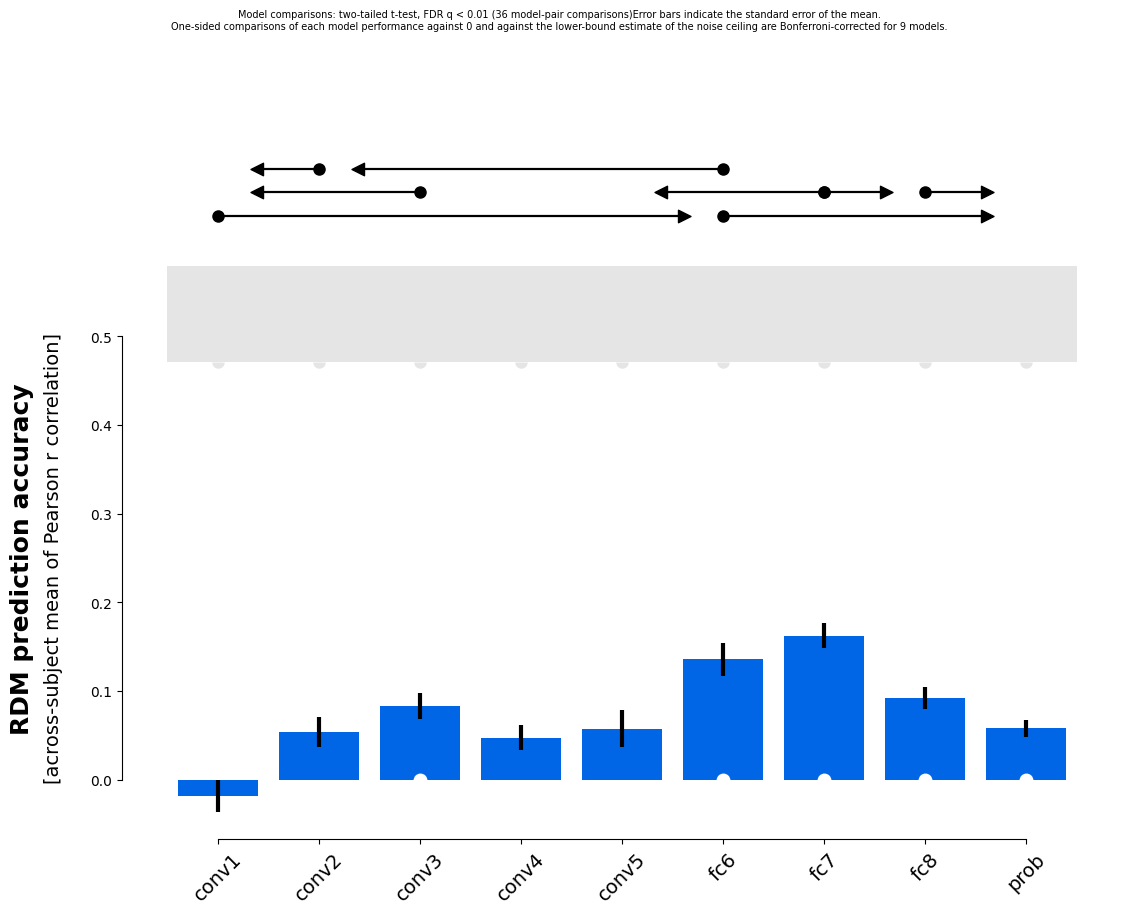

In [ ]:
results_1 = rsatoolbox.inference.eval_fixed(models, rdms_data, method='corr')
rsatoolbox.vis.plot_model_comparison(results_1)

#results_1 = rsatoolbox.inference.eval_fixed(models, rdms_data, method='spearman')
#rsatoolbox.vis.plot_model_comparison(results_1)

#results_1 = rsatoolbox.inference.eval_fixed(models, rdms_data, method='tau-a')
#rsatoolbox.vis.plot_model_comparison(results_1)

#results_1 = rsatoolbox.inference.eval_fixed(models, rdms_data, method='rho-a')
#rsatoolbox.vis.plot_model_comparison(results_1)

In these plots the errorbars are based on the variability across subjects, which can be handled analytically. The double arrows indicate all significantly different pairs: each double arrow indicates that the model marked by the dot is significantly different in performance from all models beyond the arrowheads. The upper bound of the noise ceiling is computed by finding the RDM with the highest possible average similarity to the measured RDMs. This is not 1 because the RDMs for different subjects or measurements differ. The lower bound of the noise ceiling is a leave one out crossvalidation of this averaging procedure, i.e. we find the RDM to perform optimally on all but one of the RDMs and evaluate this average RDM on the left-out RDM. Each RDM is left out once and the correlations are averaged.

To take the many pairwise model comparisons into account in performing inference, we can choose a correction for multiple comparisons: We can either control the family wise error rate (FWER) or the false discovery rate (FDR). Here we use a Bonferroni correction for FWER and the Benjamini-Hochberg procedure for FDR.

The basic information from a results object can also be printed with the simple print command:

In [ ]:
print(results_1)

Results for running fixed evaluation for corr on 9 models:

Model |   Eval ± SEM   | p (against 0) | p (against NC) |
---------------------------------------------------------
conv1 | -0.018 ± 0.018 |        0.836  |       < 0.001  |
conv2 |  0.053 ± 0.017 |        0.005  |       < 0.001  |
conv3 |  0.083 ± 0.014 |      < 0.001  |       < 0.001  |
conv4 |  0.047 ± 0.014 |        0.004  |       < 0.001  |
conv5 |  0.057 ± 0.021 |        0.010  |       < 0.001  |
fc6   |  0.136 ± 0.019 |      < 0.001  |       < 0.001  |
fc7   |  0.162 ± 0.014 |      < 0.001  |       < 0.001  |
fc8   |  0.092 ± 0.012 |      < 0.001  |       < 0.001  |
prob  |  0.058 ± 0.009 |      < 0.001  |       < 0.001  |

p-values are based on uncorrected t-tests


Furthermore, the results object has a few functions called `get_*` to access results like te mean values, errorbars, the noise ceiling etc., and `test_*` functions that return the p-values of the various tests.

### Bootstrapping


To estimate our uncertainty about the models' performance once we want to include the uncertainty due to random stimulus selection, we can perform bootstrapping.

#### Model comparison by bootstrapping the subjects
We can bootstrap resample the subjects, which estimates how variable the model performances would be if we repeted the experiment with the same stimuli but new subjects from the same population. Based on that uncertainty estimate, we can statistically compare model performances.

In the limit of many bootstrap samples this estimate converges exactly to the variance we get from the much faster analytical solution used by eval_fixed. Thus, this analysis is usually not used in praxis. It is the simplest version of bootstrapping though and thus, a good starting point to illustrate the use of the bootstrap. The following should thus results in very similar results as `results_1`.

100%|██████████| 1000/1000 [00:20<00:00, 48.50it/s]


(<Figure size 1250x1000 with 2 Axes>, <Axes: >, <Axes: >)

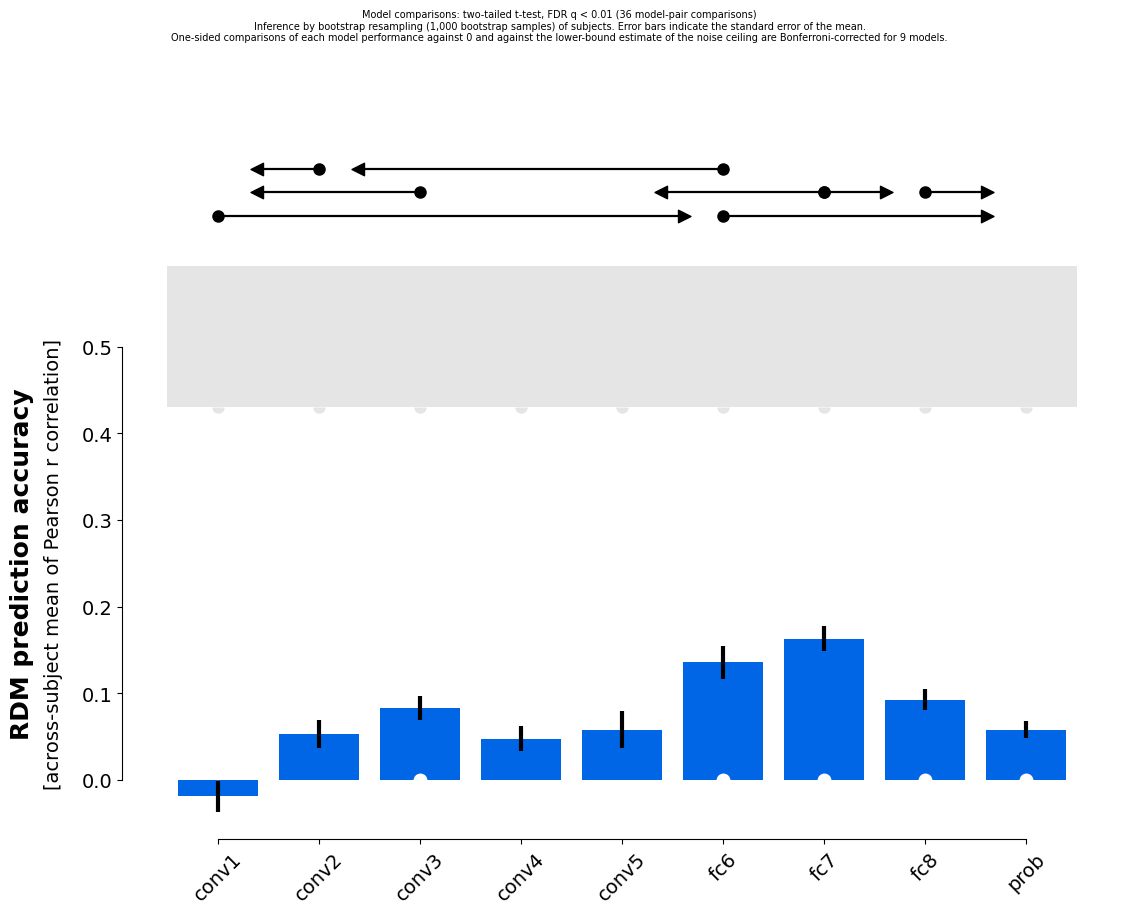

In [ ]:
results_2a = rsatoolbox.inference.eval_bootstrap_rdm(models, rdms_data, method='corr')
rsatoolbox.vis.plot_model_comparison(results_2a)

In [ ]:
print(results_2a)

Results for running bootstrap_rdm evaluation for corr on 9 models:

Model |   Eval ± SEM   | p (against 0) | p (against NC) |
---------------------------------------------------------
conv1 | -0.019 ± 0.018 |        0.840  |       < 0.001  |
conv2 |  0.053 ± 0.016 |        0.004  |       < 0.001  |
conv3 |  0.083 ± 0.014 |      < 0.001  |       < 0.001  |
conv4 |  0.047 ± 0.014 |        0.003  |       < 0.001  |
conv5 |  0.058 ± 0.021 |        0.010  |       < 0.001  |
fc6   |  0.136 ± 0.019 |      < 0.001  |       < 0.001  |
fc7   |  0.163 ± 0.014 |      < 0.001  |       < 0.001  |
fc8   |  0.093 ± 0.012 |      < 0.001  |       < 0.001  |
prob  |  0.058 ± 0.010 |      < 0.001  |       < 0.001  |

p-values are based on uncorrected t-tests


#### Model comparison by bootstrapping the stimuli
We can alternatively bootstrap resample the stimuli to estimate how much model performance would vary if we repeated the experiment with the same subjects using a new sample of stimuli from the same population. This analysis is not analytically solvable.

100%|██████████| 1000/1000 [00:34<00:00, 28.78it/s]


(<Figure size 1250x1000 with 2 Axes>, <Axes: >, <Axes: >)

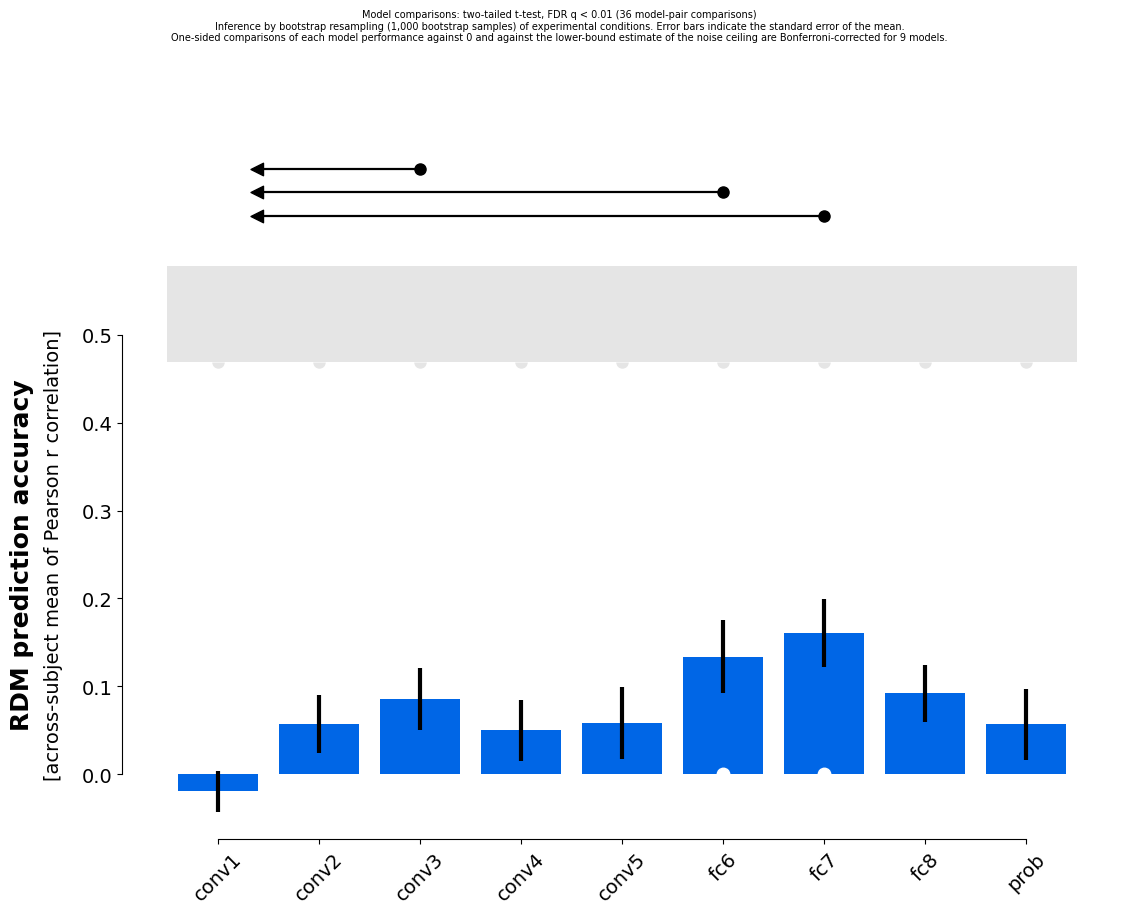

In [ ]:
results_2b = rsatoolbox.inference.eval_bootstrap_pattern(models, rdms_data, method='corr')
rsatoolbox.vis.plot_model_comparison(results_2b)

#### Model comparison by bootstrapping both stimuli and subjects
Finally, we can bootstrap resample both stimuli and subjects to estimate how variable the model performances would be if we repeated the experiment with new subjects and new stimuli from their respective populations:

100%|██████████| 1000/1000 [00:26<00:00, 37.09it/s]


(<Figure size 1250x1000 with 2 Axes>, <Axes: >, <Axes: >)

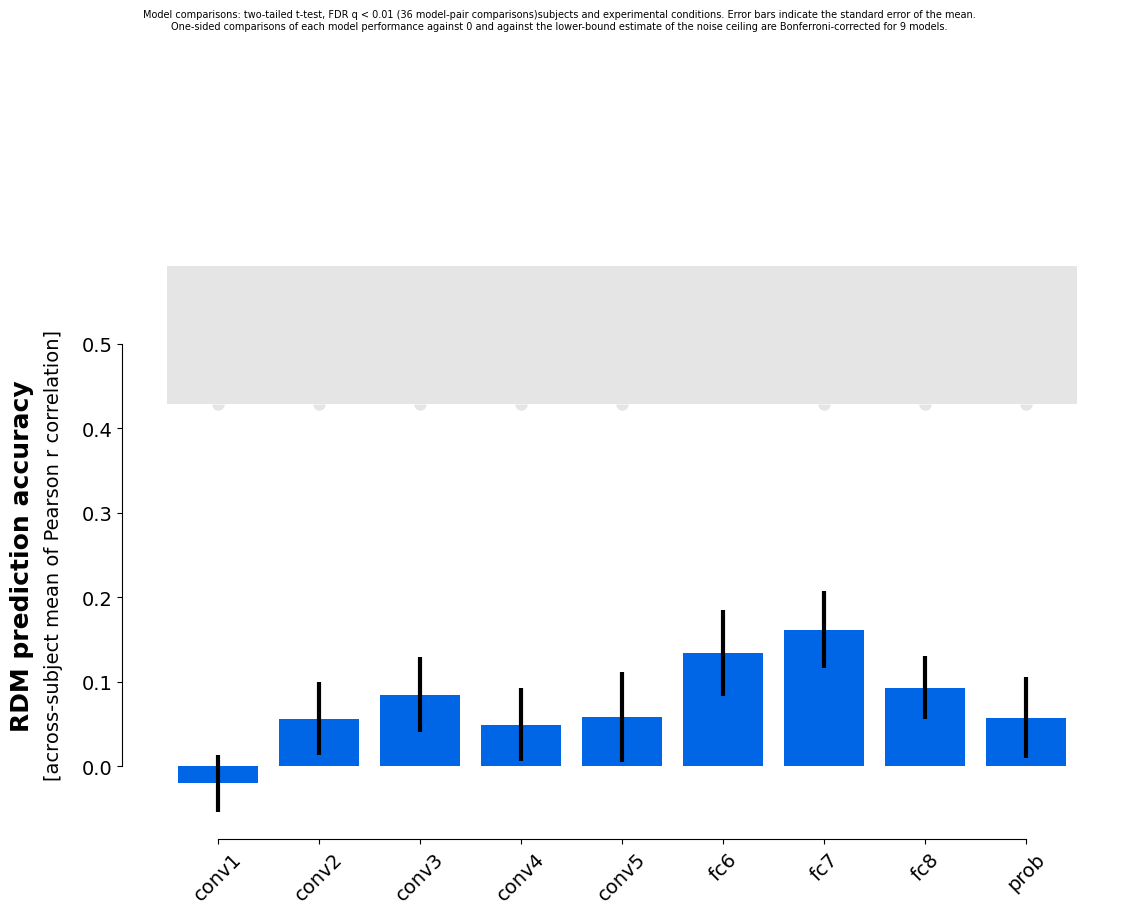

In [ ]:
results_2c = rsatoolbox.inference.eval_bootstrap(models, rdms_data, method='corr')
rsatoolbox.vis.plot_model_comparison(results_2c)

As we note in the paper "Statistical inference on representational geometries", this estimate is overly conservative though. It yields too large errorbars. To aleviate this, we there suggest a correction, based on combining the errorbars from bootstrapping both stimuli and subjects with the separate bootstraps for the two factors. This is implemented in the `eval_dual_bootstrap` method:

100%|██████████| 1000/1000 [01:42<00:00,  9.79it/s]


(<Figure size 1250x1000 with 2 Axes>, <Axes: >, <Axes: >)

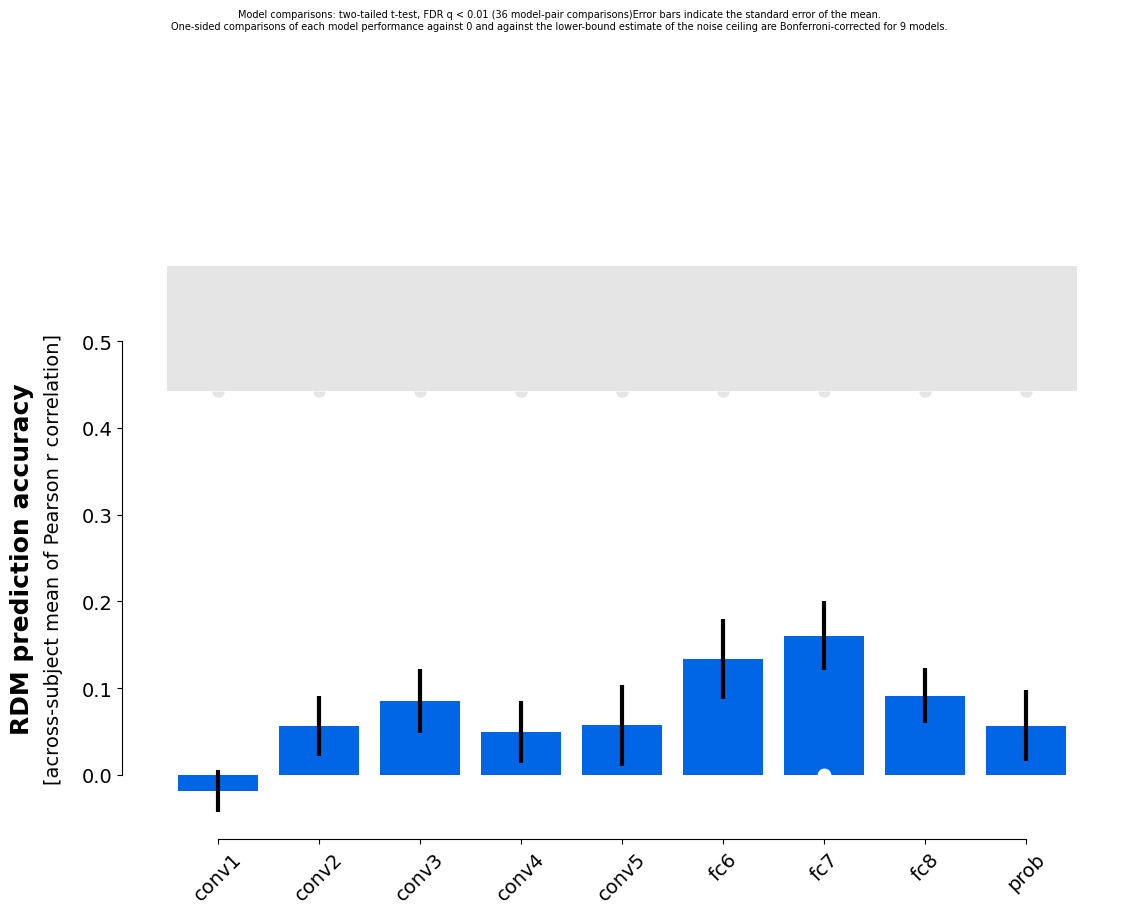

In [ ]:
results_2d = rsatoolbox.inference.eval_dual_bootstrap(models, rdms_data, method='corr')
rsatoolbox.vis.plot_model_comparison(results_2d)

Indeed, the SEMs for the model evaluations are also smaller here:

In [ ]:
print(results_2c)

Results for running bootstrap evaluation for corr on 9 models:

Model |   Eval ± SEM   | p (against 0) | p (against NC) |
---------------------------------------------------------
conv1 | -0.020 ± 0.034 |        0.717  |       < 0.001  |
conv2 |  0.057 ± 0.043 |        0.109  |       < 0.001  |
conv3 |  0.085 ± 0.044 |        0.041  |       < 0.001  |
conv4 |  0.050 ± 0.043 |        0.139  |       < 0.001  |
conv5 |  0.058 ± 0.053 |        0.150  |       < 0.001  |
fc6   |  0.134 ± 0.051 |        0.012  |         0.001  |
fc7   |  0.162 ± 0.046 |        0.002  |       < 0.001  |
fc8   |  0.093 ± 0.037 |        0.014  |       < 0.001  |
prob  |  0.058 ± 0.048 |        0.127  |       < 0.001  |

p-values are based on uncorrected t-tests


In [ ]:
print(results_2d)

Results for running dual_bootstrap evaluation for corr on 9 models:

Model |   Eval ± SEM   | p (against 0) | p (against NC) |
---------------------------------------------------------
conv1 | -0.018 ± 0.024 |        0.769  |       < 0.001  |
conv2 |  0.057 ± 0.035 |        0.065  |       < 0.001  |
conv3 |  0.085 ± 0.037 |        0.021  |       < 0.001  |
conv4 |  0.050 ± 0.036 |        0.098  |       < 0.001  |
conv5 |  0.057 ± 0.047 |        0.124  |       < 0.001  |
fc6   |  0.134 ± 0.046 |        0.007  |       < 0.001  |
fc7   |  0.160 ± 0.040 |        0.001  |       < 0.001  |
fc8   |  0.091 ± 0.032 |        0.007  |       < 0.001  |
prob  |  0.056 ± 0.041 |        0.098  |       < 0.001  |

p-values are based on uncorrected t-tests


## Exercise 3: Crossvalidation for flexible models


### Defining flexible models


Here we use a type of flexible model called a *selection model*. This type of model specifies that the true RDM is one from a list of RDMs. To evaluate flexible models, they have to be fitted to data, i.e. we need to provide some data, which can be used to adjust the RDM-prediction of the model. For a selection model, the fitting process simply selects the RDM that performs best on the training data. The model will perform better on this data than on independent data. An unbiased performance estimate therefore requires independent test data. Crossvalidation is a data-efficient way of obtaining an unbiased performance estimate.

We first have to generate the selection models. This process is the same as for fixed models, but uses `rsatoolbox.model.ModelSelect` and passes multiple RDMs instead of a single one:

In [ ]:
models_flex = []
for i_model in np.unique(model_names):
    models_flex.append(rsatoolbox.model.ModelSelect(i_model,
        model_rdms.subset('brain_computational_model', i_model)))

print('created the following models:')
for i in range(len(models_flex)):
    print(models_flex[i].name)

created the following models:
conv1
conv2
conv3
conv4
conv5
fc6
fc7
fc8
prob


### Crossvalidation


As a first step, we split our data into training and test sets, which should not share either subjects or stimuli. To do so, we split each dimension into k groups and leave one of these groups out as a testset and use all others as training data. Models choose their parameters to maximize performance on the training set and are evaluated on the test set. Additionally a so-called *ceil set* is created, which contains the data from the training subjects for the test stimuli, which is necessary for calculating a noise ceiling.

The variables `k_pattern` and `k_rdm` specify how many folds should be formed over stimuli and subjects, respectively.

In [ ]:
train_set, test_set, ceil_set = rsatoolbox.inference.sets_k_fold(rdms_data, k_pattern=3, k_rdm=2)

With these sets we can now evaluate our models, as we did without crossvalidaton, and plot the results. The performance estimates will be averaged across folds and we obtain a single performance estimate without errorbars. The variability over cross-validation folds are not indicative of the variability across independent datasets. Although training and test data are independent of each other in each fold, performance estimates are not independent across folds of crossvalidation.

/usr/local/lib/python3.10/dist-packages/rsatoolbox/vis/model_plot.py:232: UserWarning: tests deactivated as crossvalidation does notprovide uncertainty estimate
  warnings.warn('tests deactivated as crossvalidation does not'
/usr/local/lib/python3.10/dist-packages/rsatoolbox/vis/model_plot.py:238: UserWarning: errorbars deactivated as crossvalidation does notprovide uncertainty estimate
  warnings.warn('errorbars deactivated as crossvalidation does not'


(<Figure size 1250x1000 with 1 Axes>, <Axes: >, None)

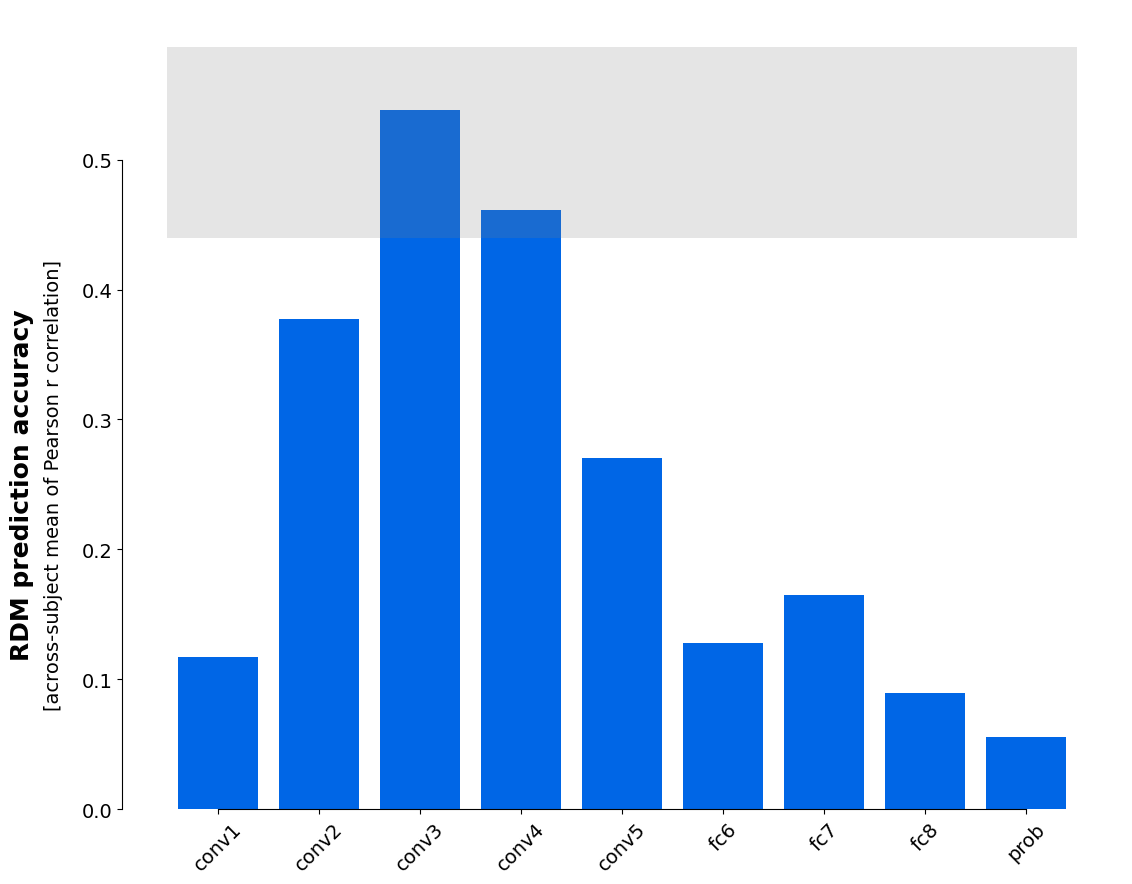

In [ ]:
results_3_cv = rsatoolbox.inference.crossval(models_flex, rdms_data, train_set, test_set,
                                        ceil_set=ceil_set, method='corr')
# plot results
rsatoolbox.vis.plot_model_comparison(results_3_cv)

### Bootstrapped Crossvalidation



We can perform bootstrapping around the crossvalidation to get uncertainty estimates for the evaluation and for model comparison. This is implemented in the eval_dual_bootstrap method and can be activated by simply changing the k_pattern and k_rdm inputs. Here we compute only 100 bootstrap samples to keep the computation time short enough for demonstrations. For accurate inference, please run more samples of course!

This method internally applies the crossvalidation variance correction we introduce in the paper "Statistical inference on representational geometries".

100%|██████████| 100/100 [03:58<00:00,  2.39s/it]


(<Figure size 1250x1000 with 2 Axes>, <Axes: >, <Axes: >)

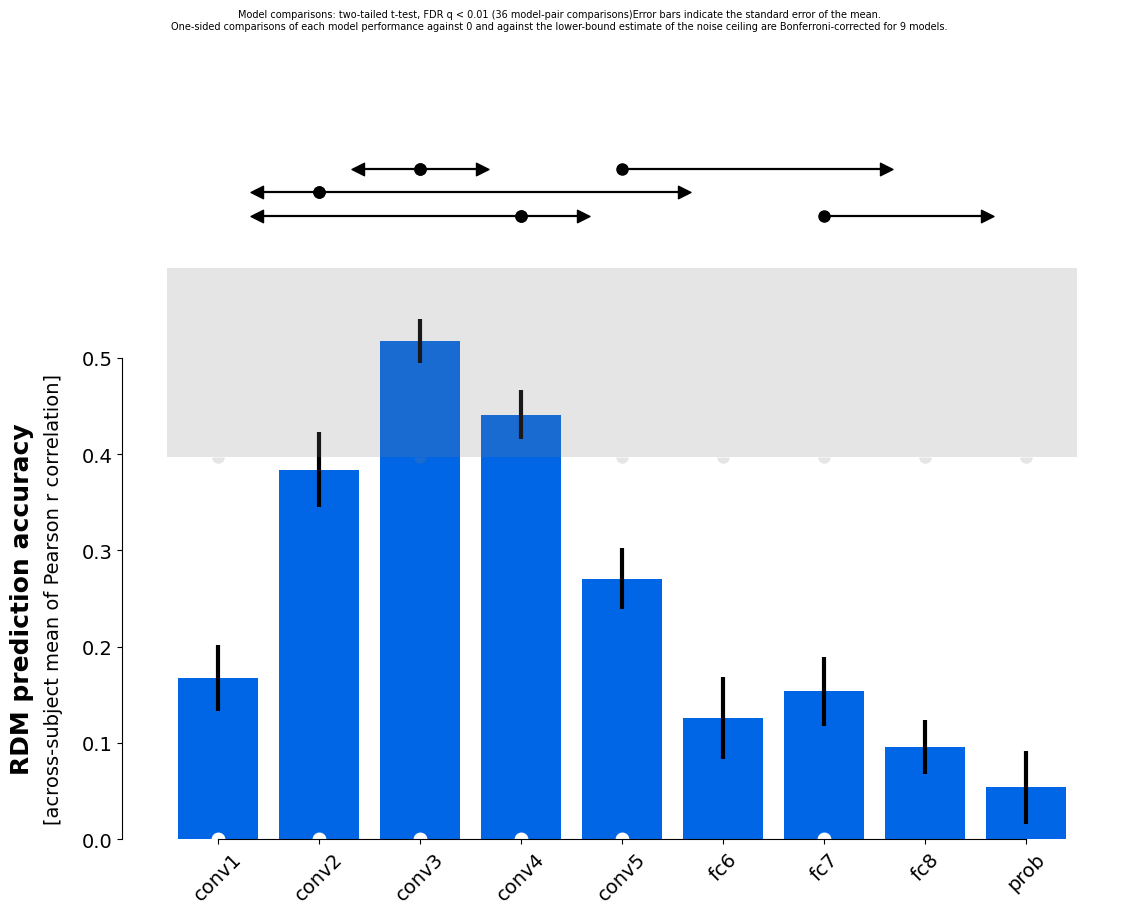

In [ ]:
results_3_full = rsatoolbox.inference.eval_dual_bootstrap(models_flex, rdms_data, k_pattern=4, k_rdm=2, method='corr', N=100)
# plot results
rsatoolbox.vis.plot_model_comparison(results_3_full)